# Sweeps - Impedance, scattering and admittance (Z S Y) matrices

## Notebook Reference:

https://uscedu-my.sharepoint.com/personal/lflab_usc_edu/_layouts/OneNote.aspx?id=%2Fpersonal%2Flflab_usc_edu%2FDocuments%2FSimulations&wd=target%28CandleQubit.one%7C602DD33E-CA0E-47CA-8840-8B1DC369F251%2F%29
onenote:https://uscedu-my.sharepoint.com/personal/lflab_usc_edu/Documents/Simulations/CandleQubit.one#section-id={602DD33E-CA0E-47CA-8840-8B1DC369F251}&end

## Simulation Notebooks:



### Prerequisite
You need to have a working local installation of Ansys

## 1. Perform the necessary imports and create a QDesign in Metal first.

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, Headings
import pyEPR as epr
from qiskit_metal.analyses.simulation import ScatteringImpedanceSim

## Create the design in Metal
 Set up a design of a given dimension.  Create a design by specifying the chip size and open Metal GUI.  Dimensions will be respected in the design rendering.  Note the chip design is centered at origin (0,0).

In [ ]:
design = designs.DesignPlanar({}, True)
design.chips.main.size['size_x'] = '2mm'
design.chips.main.size['size_y'] = '2mm'

gui = MetalGUI(design)

# Perform the necessary imports.
from qiskit_metal.qlibrary.couplers.coupled_line_tee import CoupledLineTee
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal.qlibrary.qubits.transmon_pocket import TransmonPocket
from qiskit_metal.qlibrary.tlines.straight_path import RouteStraight
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround

In [ ]:
# To create plots after geting solution data.
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Add 2 transmons to the design.
options = dict(
    # Some options we want to modify from the deafults
    # (see below for defaults)
    pad_width='425 um',
    pocket_height='650um',
    # Adding 4 connectors (see below for defaults)
    connection_pads=dict(a=dict(loc_W=+1, loc_H=+1),
                         b=dict(loc_W=-1, loc_H=+1, pad_height='30um'),
                         c=dict(loc_W=+1, loc_H=-1, pad_width='200um'),
                         d=dict(loc_W=-1, loc_H=-1, pad_height='50um')))

## Create 2 transmons
q1 = TransmonPocket(design,
                    'Q1',
                    options=dict(pos_x='+1.4mm',
                                 pos_y='0mm',
                                 orientation='90',
                                 **options))
q2 = TransmonPocket(design,
                    'Q2',
                    options=dict(pos_x='-0.6mm',
                                 pos_y='0mm',
                                 orientation='90',
                                 **options))

gui.rebuild()
gui.autoscale()

In [ ]:
# Add 2 hangers consisting of capacitively coupled transmission lines.
TQ1 = CoupledLineTee(design,
                     'TQ1',
                     options=dict(pos_x='1mm',
                                  pos_y='3mm',
                                  coupling_length='500um',
                                  coupling_space='1um'))
TQ2 = CoupledLineTee(design,
                     'TQ2',
                     options=dict(pos_x='-1mm',
                                  pos_y='3mm',
                                  coupling_length='500um',
                                  coupling_space='1um'))

gui.rebuild()
gui.autoscale()

In [ ]:
# Add 2 meandered CPWs connecting the transmons to the hangers.
ops = dict(fillet='90um')
design.overwrite_enabled = True

options1 = Dict(total_length='8mm',
                hfss_wire_bonds=True,
                pin_inputs=Dict(start_pin=Dict(component='TQ1',
                                               pin='second_end'),
                                end_pin=Dict(component='Q1', pin='a')),
                lead=Dict(start_straight='0.1mm'),
                **ops)

options2 = Dict(total_length='9mm',
                hfss_wire_bonds=True,
                pin_inputs=Dict(start_pin=Dict(component='TQ2',
                                               pin='second_end'),
                                end_pin=Dict(component='Q2', pin='a')),
                lead=Dict(start_straight='0.1mm'),
                **ops)

meanderQ1 = RouteMeander(design, 'meanderQ1', options=options1)
meanderQ2 = RouteMeander(design, 'meanderQ2', options=options2)

gui.rebuild()
gui.autoscale() 

In [ ]:
# Add 2 open to grounds at the ends of the horizontal CPW.
otg1 = OpenToGround(design, 'otg1', options=dict(pos_x='3mm', pos_y='3mm'))
otg2 = OpenToGround(design,
                    'otg2',
                    options=dict(pos_x='-3mm', pos_y='3mm', orientation='180'))

gui.rebuild()
gui.autoscale()

# Add 3 straight CPWs that comprise the long horizontal CPW.

ops_oR = Dict(hfss_wire_bonds=True,
              pin_inputs=Dict(start_pin=Dict(component='TQ1', pin='prime_end'),
                              end_pin=Dict(component='otg1', pin='open')))
ops_mid = Dict(hfss_wire_bonds=True,
               pin_inputs=Dict(start_pin=Dict(component='TQ1',
                                              pin='prime_start'),
                               end_pin=Dict(component='TQ2', pin='prime_end')))
ops_oL = Dict(hfss_wire_bonds=True,
              pin_inputs=Dict(start_pin=Dict(component='TQ2',
                                             pin='prime_start'),
                              end_pin=Dict(component='otg2', pin='open')))

cpw_openRight = RouteStraight(design, 'cpw_openRight', options=ops_oR)
cpw_middle = RouteStraight(design, 'cpw_middle', options=ops_mid)
cpw_openLeft = RouteStraight(design, 'cpw_openLeft', options=ops_oL)

gui.rebuild()
gui.autoscale()

In [ ]:
gui.screenshot()

## 2. Render the qubit from Metal into the HangingResonators design in Ansys. <br>ScatteringImpedanceSim will  open the simulation software. Then will connect, activate the design, add a setup.  

Review and update the setup. For driven modal you will need to define not only the simulation convergence parameters, but also the frequency sweep.




In [ ]:
em1 = ScatteringImpedanceSim(design, "hfss")

Customizable parameters and default values for HFSS (driven  modal):

    freq_ghz=5 (simulation frequency)
    name="Setup" (setup name)
    max_delta_s=0.1 (absolute value of maximum difference in scattering parameter S)
    max_passes=10 (maximum number of passes)
    min_passes=1 (minimum number of passes)
    min_converged=1 (minimum number of converged passes)
    pct_refinement=30 (percent refinement)
    basis_order=1 (basis order)
    vars (global variables to set in the renderer)
    sweep_setup (all the parameters of the sweep)
    name="Sweep" (name of sweep)
    start_ghz=2.0 (starting frequency)
    stop_ghz=8.0 (stopping frequency)
    count=101 (total number of frequencies)
    step_ghz=None (frequency step size)
    type="Fast" (type of sweep)
    save_fields=False (whether or not to save fields)

In [ ]:
# To view the values for defaults. 
em1.setup

In [ ]:
em1.setup.name = "Sweep_DrivenModal_setup"
em1.setup.freq_ghz = 6.0
em1.setup.max_delta_s = 0.05
em1.setup.max_passes = 12
em1.setup.min_passes = 2


Add a frequency sweep to a driven modal setup.<br>
From QHFSSRenderer.add_sweep doc_strings.  Please go to doc_strings to get the latest information.  

Args:<br>
    setup_name (str, optional): Name of driven modal simulation Sweep.
                            Defaults to "Setup".<br>
    start_ghz (float, optional): Starting frequency of sweep in GHz.
                            Defaults to 2.0.<br>
    stop_ghz (float, optional): Ending frequency of sweep in GHz.
                            Defaults to 8.0.<br>
    count (int, optional): Total number of frequencies.
                            Defaults to 101.<br>
    step_ghz (float, optional): Difference between adjacent
                            frequencies. Defaults to None.<br>
    name (str, optional): Name of sweep. Defaults to "Sweep".<br>
    type (str, optional): Type of sweep. Defaults to "Fast".<br>
    save_fields (bool, optional): Whether or not to save fields.
                        Defaults to False.<br>
                        
                        
From pyEPR.HfssSetup.insert_sweep(), please go to this method to get the latest documentation.   
You should provide either step_ghz or count when inserting an HFSS driven model freq sweep. Do not provide both or neither!

In [ ]:
# To view the values for defaults. 
em1.setup.sweep_setup

In [ ]:
em1.setup.sweep_setup.name="Sweep_options__dm_sweep"
em1.setup.sweep_setup.start_ghz=4.0
em1.setup.sweep_setup.stop_ghz=9.0
em1.setup.sweep_setup.count=5001
em1.setup.sweep_setup.type="Interpolating"


em1.setup

In [ ]:
# Set the buffer width at the edge of the design to be 0.5 mm 
# in both directions.
em1.setup.renderer.options['x_buffer_width_mm'] = 0.5
em1.setup.renderer.options['y_buffer_width_mm'] = 0.5

In [ ]:
#     qcomp_name (str): A component that contains the option to be swept.
#     option_name (str): The option within qcomp_name to sweep.
#     option_sweep (list): Each entry in the list is a value for
#                 option_name.
#     qcomp_render (list): The component to render to simulation.
#     open_terminations (list): Identify which kind of pins. Follow the
#                 details from renderer QQ3DRenderer.render_design, or
#                 QHFSSRenderer.render_design.
#     port_list (list): List of tuples of jj's that shouldn't
#                     be rendered.  Follow details from
#                     renderer in QHFSSRenderer.render_design.
#     jj_to_port (list): List of junctions (qcomp, qgeometry_name,
#                         impedance, draw_ind) to render as lumped ports
#                         or as lumped port in parallel with a sheet
#                         inductance.    Follow details from renderer
#                         in QHFSSRenderer.render_design.
#     ignored_jjs (Union[list,None]): This is not used by all renderers,
#                  just hfss.
#     design_name(str): Name of design (workspace) to use in project.
#     box_plus_buffer(bool): Render the entire chip or create a
#                 box_plus_buffer around the components which are rendered.


In [ ]:

design_name= "Sweep_DrivenModal"
qcomp_render = [] # Means to render everything in qgeometry table.
open_terminations = []

# Here, pin cpw_openRight_end and cpw_openLeft_end are converted into lumped ports,
#           each with an impedance of 50 Ohms. <br>
port_list = [('cpw_openRight', 'end', 50),
                      ('cpw_openLeft', 'end', 50)]
jj_to_port = [('Q1', 'rect_jj', 50, False)]
# Neither of the junctions in Q1 or Q2 are rendered.
ignored_jjs = [('Q2', 'rect_jj')]
box_plus_buffer = True

In [ ]:
#Note: The method will connect to  Ansys simulation, activate_drivenmodal_design(), add_drivenmodal_setup().

all_sweeps, return_code = em1.run_sweep(meanderQ1.name,
                                        'total_length', 
                                        ['9mm', '10mm', '11mm'],
                                        qcomp_render,
                                        open_terminations,
                                        design_name=design_name,
                                        port_list = port_list,
                                        jj_to_port= jj_to_port,
                                        ignored_jjs= ignored_jjs,
                                        box_plus_buffer=box_plus_buffer
                                       )

#Note: Sweep again using the arguments from previous run.  
```
all_sweeps_6_7_8, return_code = em1.run_sweep(meanderQ1.name,
                                        'total_length', 
                                        ['6.5mm', '7.5mm', '8.5mm']
                                       )
```

In [ ]:

if return_code == 0:
    # Each key corresponds to list passed to ['9mm', '8mm', '7mm']
    print(all_sweeps.keys())
    
    # Each key corresponds to list passed to ['6mm', '5mm', '4mm']
    # print(all_sweeps_6_7_8.keys())
else:
    print('Check warning messages to see why all_sweeps is non-zero.')


In [ ]:
all_sweeps['9mm'].keys()

In [ ]:
all_sweeps['9mm']['variables']

In [ ]:
all_sweeps['9mm']['option_name']


In [ ]:
print(f"""
project_name = {em1.renderer.pinfo.project_name}
design_name  = {em1.renderer.pinfo.design_name}
setup_name   = {em1.renderer.pinfo.setup_name}
""")

Note: Results storage is currently being updated to be fully functional with the sweep functionality.

In [ ]:
em1.get_impedance()                # default: ['Z11', 'Z21']

In [ ]:
em1.get_admittance()              # default: ['Y11', 'Y21']

In [ ]:
em1.get_scattering(['S11', 'S21', 'S31'])          ## default: ['S11', 'S21', 'S22']

In [ ]:
dataframe_scattering = em1.get_scattering(['S11', 'S21', 'S31'])
df_s = dataframe_scattering[0]

In [ ]:
df_s.to_csv("df_s.csv")

In [ ]:
dataframe_scattering[1]
plt.show()

In [ ]:
s11 = df_s['S11']
s11

s21 = df_s['S21']
s21

s31 = df_s['S31']
s31

In [ ]:
dataframe_scattering[0]['20_log_of_mag_S11']= 20 * np.log10(np.absolute(s11))
dataframe_scattering[0]['20_log_of_mag_S21']= 20 * np.log10(np.absolute(s21))
dataframe_scattering[0]['20_log_of_mag_S31']= 20 * np.log10(np.absolute(s31))
dataframe_scattering[0]

In [ ]:
# Reference to current axis. 
magnitude = plt.figure('Magnitude S11, S21, and S31')
plt.clf()
axis = plt.gca() # Get current axis.
dataframe_scattering[0].plot(kind = 'line', y='20_log_of_mag_S11', color = 'green', ax = axis)
dataframe_scattering[0].plot(kind = 'line', y='20_log_of_mag_S21', color = 'blue', ax = axis)
dataframe_scattering[0].plot(kind = 'line', y='20_log_of_mag_S31', color = 'red', ax = axis)
plt.title(f'S-Parameter Magnitude')
plt.xlabel(f'frequency [GHZ]')
plt.ylabel(f'|S11|,|S21|,|S31| [dB]')
magnitude.show()

In [ ]:
# Data is shown as degrees.  
# However, if you want radians, change value of deg to false, deg=False.
dataframe_scattering[0]['degrees_S11'] = np.angle(s11, deg=True)
dataframe_scattering[0]['degrees_S21'] = np.angle(s21, deg=True)
dataframe_scattering[0]['degrees_S31'] = np.angle(s31, deg=True)
dataframe_scattering[0]

In [ ]:
# Reference to current axis. 
phase = plt.figure('Phase of S11 and S21')
plt.clf()
axis = plt.gca() # Get current axis.
dataframe_scattering[0].plot(kind = 'line', y='degrees_S11', color = 'green', ax = axis)
dataframe_scattering[0].plot(kind = 'line', y='degrees_S21', color = 'blue', ax = axis)
dataframe_scattering[0].plot(kind = 'line', y='degrees_S31', color = 'red', ax = axis)
plt.title(f'S-Parameter Phase')
plt.xlabel(f'frequency [GHZ]')
plt.ylabel(f'<S11, <S21, <S31 [degrees]')
phase.show()

In [ ]:
em1.close()

In [ ]:
# Uncomment next line if you would like to close the gui
# gui.main_window.close()

# Analysis to Get Kappa

1. Get the real and imaginary parts of the scattering parameter of interest (e.g. S21)

    ```python
    def get_real_and_imag(a_ii):
        return a_ii.values.real, a_ii.values.imag

    s21real, s21imag = get_real_and_imag(df_s['S21'])
    ```
2. Get the frequency and volatage data

    ```python
    freqs = df_s["freqs"] * 1e9
    I = s21real
    Q = s21imag
    ```
    
3. Use the `Resonator` code to fit the data

    ```python
    from metal_library.utils.fitTools import Resonator
    res = Resonator(f_data=freqs,z_data=I + 1j*Q)
    ```

4. Use the `autofit`, `show` and print methods to retrieve all info

    ```python
    res.autofit()
    res.show()
    print(res)
    ```
    
5. Extract $\kappa$ simply as an attribute of `res`

    ```python
    kappa = res.kappa
    ```

In [107]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
!pip install ../.

Processing /Users/shanto/LFL/SQuADDS/metal-library
  Preparing metadata (setup.py) ... done
  Created wheel for metal-library: filename=metal_library-1.0.0-py3-none-any.whl size=574785 sha256=fa224df9fe907b2453066a367bc63eb4483221b18044126774929586c0f47421
  Stored in directory: /Users/shanto/Library/Caches/pip/wheels/cc/d5/e7/b9339b9dd36479ed23f7215b35ff24f41883f4ab86f5bb5ea7
Successfully built metal-library
  Attempting uninstall: metal-library
    Found existing installation: metal-library 1.0.0
    Uninstalling metal-library-1.0.0:
      Successfully uninstalled metal-library-1.0.0


In [109]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [54]:
from metal_library.utils.fitTools import Resonator

In [124]:
df_s = pd.read_csv("df_s.csv")
df_s.rename(columns={"Unnamed: 0": "freqs"}, inplace=True)


In [125]:
df_s

,freqs,S11,S21,S31
0,4.000,(-0.12903643644488-0.022905344376546j),(-0.268184846601751+0.954411756152637j),(-0.000155380337150258-8.30444471059751e-05j)
1,4.001,(-0.1290558774394764-0.02286191005059115j),(-0.2678774519461429+0.9544965157605392j),(-0.0001560162000813666-8.333190231419711e-05j)
2,4.002,(-0.1290752936768674-0.02281846019191276j),(-0.2675700283063125+0.954581178117679j),(-0.000156656562354994-8.362134581135745e-05j)
3,4.003,(-0.1290946851845806-0.02277499479680794j),(-0.2672625756720265+0.9546657432210167j),(-0.0001573014713627178-8.391279848005136e-05j)
4,4.004,(-0.1291140519906685-0.02273151386126351j),(-0.2669550940324897+0.9547502110675541j),(-0.0001579509751504956-8.420628150114406e-05j)
...,...,...,...,...
4996,8.996,(0.01104640180317001+0.02647019629829554j),(0.973153038269149+0.2283850720378314j),(-0.0003083050943209333+0.0003315997854837787j)
4997,8.997,(0.01105794385916324+0.02642849988229308j),(0.9732289612622124+0.2280606131837082j),(-0.0003078891857698787+0.0003313377316631853j)
4998,8.998,(0.01106949108905963+0.02638684212785398j),(0.9733047522852515+0.2277360800503471j),(-0.0003074744828145532+0.0003310766769749086j)
4999,8.999,(0.0110810444781649+0.02634522271852255j),(0.9733804107137735+0.227411472352061j),(-0.0003070609797084057+0.0003308166181232908j)


In [113]:
def get_real_and_imag(a_ii):
    return a_ii.values.real, a_ii.values.imag

s21real, s21imag = get_real_and_imag(df_s['S21'])
#y11real, y11imag = get_real_and_imag(df_y['Y11'])

In [138]:
s21real

array(['(-0.268184846601751+0.954411756152637j)',
       '(-0.2678774519461429+0.9544965157605392j)',
       '(-0.2675700283063125+0.954581178117679j)', ...,
       '(0.9733047522852515+0.2277360800503471j)',
       '(0.9733804107137735+0.227411472352061j)',
       '(0.9734559359118592+0.2270867898050934j)'], dtype=object)

In [133]:
freqs = df_s["freqs"]
I = s21real
Q = s21imag

In [5]:
%matplotlib inline

In [144]:
import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_csv("freqs_I_Q.csv")

# Extract the columns into variables
freqs = df['freqs'].to_numpy()
I = df['I'].to_numpy()
Q = df['Q'].to_numpy()


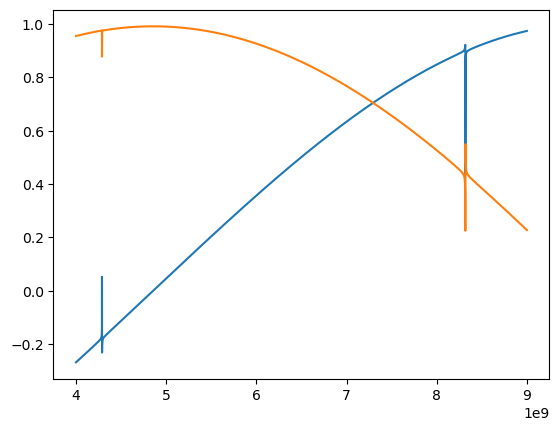

In [146]:
plt.plot(freqs,I)
plt.plot(freqs,Q)
plt.show()

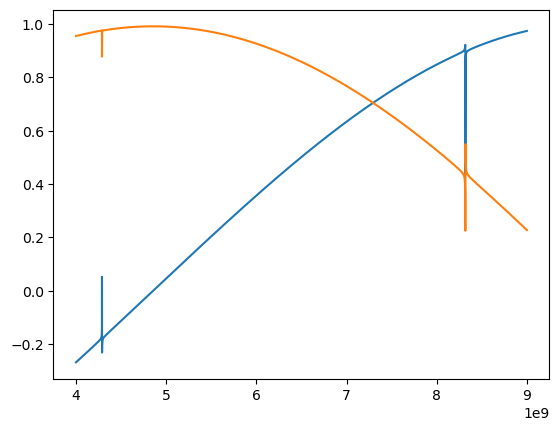

In [147]:
plt.plot(freqs,I)
plt.plot(freqs,Q)
plt.show()

In [85]:
llim, ulim = 4000,4500

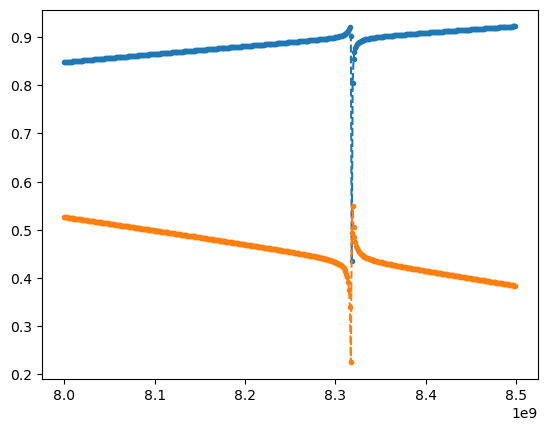

In [86]:
plt.plot(freqs[llim:ulim],I[llim:ulim],"--.")
plt.plot(freqs[llim:ulim],Q[llim:ulim],"--.")
plt.show()

In [98]:
res = Resonator(f_data=freqs,z_data=I + 1j*Q)

In [104]:
res.autofit()

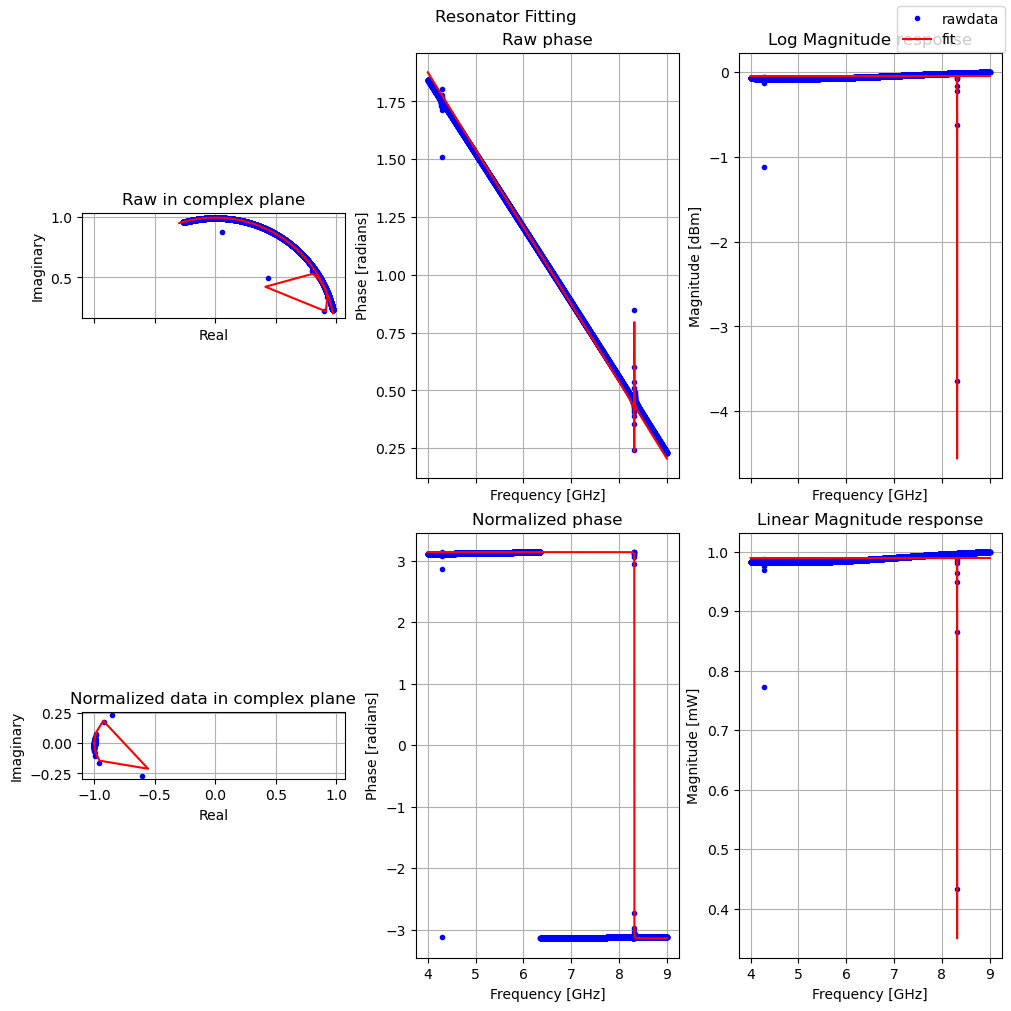

In [105]:
res.show()

In [106]:
if res.fit_found:
    print(20*"=")
    print(res)
    print(20*"="+"\n")

Frequency: 8.3178 GHz
Total Q: 12533
Internal Q: 17220
Coupling Q: 46044
FWHM: 0.66368 MHz
Kappa: 4.17000 MHz
Single Photon Power: -136.8 dBm
Ringdown Time: 0.332 us
Impedance Mismatch -8.845 degrees
Electrical Delay: 0.053217 ns
SNR: 3640.9



In [102]:
kappa = res.kappa